In [1]:
import duckdb
import pandas as pd
import plotly.express as px
DATABASE = "database.db"

In [2]:
with duckdb.connect(DATABASE) as con:
    con.sql("""
        CREATE OR REPLACE TABLE wr1_wr2 AS
        SELECT *
        FROM weekly_data
        JOIN game_data ON game_data.game_id = weekly_data.game_id AND game_data.team = weekly_data.team
        JOIN wr_data ON wr_data.player_id = weekly_data.player_id
        WHERE wr1_played = 1 AND wr2_played = 1
        ORDER BY weekly_data.team, weekly_data.game_id, weekly_data.week
        ;
    """)


    con.sql("""
        CREATE OR REPLACE TABLE wr2_only AS
        SELECT *
        FROM weekly_data
        JOIN game_data ON game_data.game_id = weekly_data.game_id AND game_data.team = weekly_data.team
        JOIN wr_data ON wr_data.player_id = weekly_data.player_id
        WHERE wr1_played = 0 AND wr2_played = 1
        ORDER BY weekly_data.team, weekly_data.game_id, weekly_data.week
        ;
    """)
    

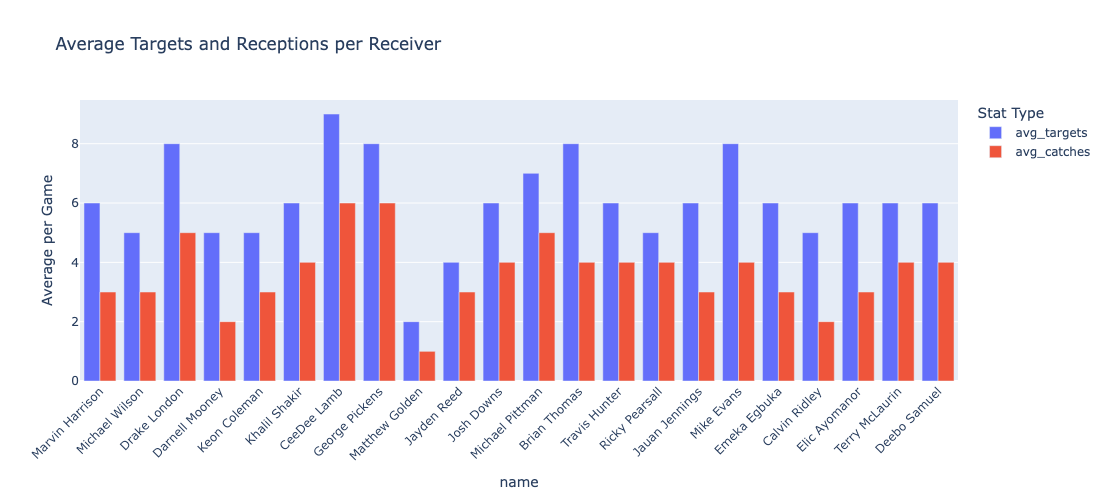

In [6]:
teams = ["ATL", "ARI", "BUF", "DAL", "GB", "IND", "JAX", "SF", "TB", "TEN", "WAS"]

with duckdb.connect(DATABASE) as con:
    df_wr1_wr2 = con.sql("""
        SELECT player_id, name, current_team_x, depth_chart_rank, ROUND(AVG(receiving_targets)) AS avg_targets, ROUND(AVG(snaps)) AS avg_snaps, ROUND(AVG(receiving_catches)) AS avg_catches, ROUND(AVG(receiving_yards),1) AS avg_yards
        FROM wr1_wr2
        GROUP BY player_id, current_team_x, name, depth_chart_rank
        ORDER BY current_team_x, depth_chart_rank
        ;
    """).df()

plot_df = df_wr1_wr2.melt(
    id_vars=["name", "current_team_x"],
    value_vars=["avg_targets", "avg_catches"],
    var_name="stat",
    value_name="value"
)
plot_df = plot_df[plot_df["current_team_x"].isin(teams)]

fig = px.bar(
    plot_df,
    x="name",   # receiver
    y="value",       # stat value
    color="stat",    # Targets and Receptions stacked
    hover_data=["current_team_x"],  # show team on hover
    title="Average Targets and Receptions per Receiver",
    labels={
        "player_id": "Receiver",
        "value": "Average per Game",
        "stat": "Stat Type"
    }
)

# Make it stacked
fig.update_layout(
    barmode="group",
    xaxis_tickangle=-45,
    height=500
)

fig.show()

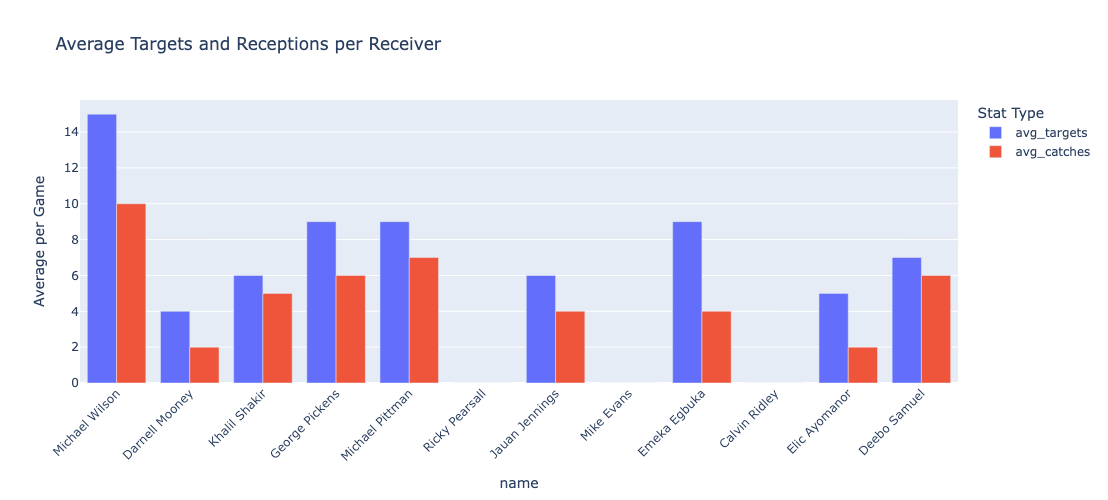

In [7]:
teams = ["ATL", "ARI", "BUF", "DAL", "GB", "IND", "JAX", "SF", "TB", "TEN", "WAS"]

with duckdb.connect(DATABASE) as con:
    df_wr2_only = con.sql("""
        SELECT player_id, name, current_team_x, depth_chart_rank, ROUND(AVG(receiving_targets)) AS avg_targets, ROUND(AVG(snaps)) AS avg_snaps, ROUND(AVG(receiving_catches)) AS avg_catches, ROUND(AVG(receiving_yards),1) AS avg_yards
        FROM wr2_only
        GROUP BY player_id, current_team_x, name, depth_chart_rank
        ORDER BY current_team_x, depth_chart_rank
        ;
    """).df()

plot_df = df_wr2_only.melt(
    id_vars=["name", "current_team_x"],
    value_vars=["avg_targets", "avg_catches"],
    var_name="stat",
    value_name="value"
)
plot_df = plot_df[plot_df["current_team_x"].isin(teams)]

fig = px.bar(
    plot_df,
    x="name",   # receiver
    y="value",       # stat value
    color="stat",    # Targets and Receptions stacked
    hover_data=["current_team_x"],  # show team on hover
    title="Average Targets and Receptions per Receiver",
    labels={
        "player_id": "Receiver",
        "value": "Average per Game",
        "stat": "Stat Type"
    }
)

# Make it stacked
fig.update_layout(
    barmode="group",
    xaxis_tickangle=-45,
    height=500
)

fig.show()

In [8]:
with duckdb.connect(DATABASE) as con:
    con.sql("""
        SELECT *
        FROM wr2_only
        ;
    """).show()

┌───────────────┬─────────┬───────────┬───────────┬────────┬───────┬─────────┬──────────┬───────────────┬───────────────────┬───────────────────┬─────────────────┬───────┬───────────┬─────────┬────────┬────────────┬────────────┬─────────────┬──────────────────┬────────────┬────────────────┬─────────────────┬────────────────┬────────────┬────────────────┬─────────────────┐
│    stat_id    │ week_id │ player_id │  game_id  │ season │ week  │  team   │ opponent │   played_at   │ receiving_targets │ receiving_catches │ receiving_yards │ snaps │ game_id_1 │ team_1  │ week_1 │ wr1_played │ wr2_played │ player_id_1 │ depth_chart_rank │ position_x │ current_team_x │ jersey_number_x │      name      │ position_y │ current_team_y │ jersey_number_y │
│    varchar    │ varchar │   int64   │   int64   │ int64  │ int64 │ varchar │ varchar  │     int64     │       int64       │       int64       │      int64      │ int64 │   int64   │ varchar │ int64  │   int32    │   int32    │    int64    │      in